# Evaluation

In [2]:
import json
import torch
import torchvision.transforms as transforms
from PIL import Image
from pathlib import Path
from tqdm import tqdm
from dinov2.models.vision_transformer import DinoVisionTransformer, vit_large
from dinov2.models.vision_transformer import vit_base
from torchvision.transforms import ToTensor,ToPILImage

/home/stud/m/mc085/mounted_home/dinov2/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/stud/m/mc085/mounted_home/dinov2/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/stud/m/mc085/mounted_home/dinov2/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [16]:
def extract_max_knn_performance(file_path):
    max_accuracy = None
    with open(file_path, "r") as file:
        for line in file:
            data = json.loads(line)
            for value in data.values():
                if max_accuracy is None or value > max_accuracy:
                    max_accuracy = value
    return max_accuracy if max_accuracy is not None else None

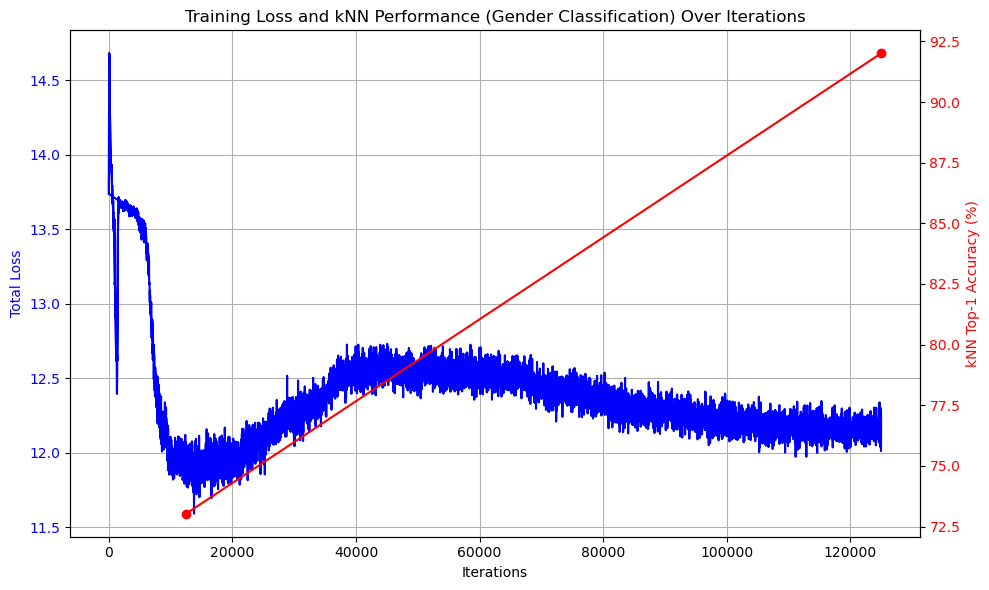

In [18]:
metrics_file = "./CelebA_gt/training_metrics.json"
knn_files = {
    12499: "./CelebA_gt/eval/training_12499/knn_gender_with_original_val_dataset/results_eval_knn.json",
    124999: "./CelebA_gt/eval/training_124999/knn_gender_with_original_val_dataset/results_eval_knn.json",
}
knn_points = {
    checkpoint: extract_max_knn_performance(path)
    for checkpoint, path in knn_files.items()
}

with open(metrics_file, "r") as file:
    metrics = [json.loads(line) for line in file]

iterations = [entry["iteration"] for entry in metrics]
total_loss = [entry["total_loss"] for entry in metrics]

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(iterations, total_loss, label="Total Loss", color="blue")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Total Loss", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.grid(True)

ax2 = ax1.twinx()
checkpoints = list(knn_points.keys())
knn_accuracies = list(knn_points.values())
ax2.plot(checkpoints, knn_accuracies, label="kNN Top-1 Accuracy", color="red", marker="o", linestyle="-")
ax2.set_ylabel("kNN Top-1 Accuracy (%)", color="red")
ax2.tick_params(axis="y", labelcolor="red")

plt.title("Training Loss and kNN Performance (Gender Classification) Over Iterations")
fig.tight_layout()

plt.show()

**Comment:** Loss curve is similar to: https://github.com/facebookresearch/dinov2/issues/143#issuecomment-1651732518
TODO: Perform knn- and linear evaluation for each teacher checkpoint and plot the results. Then compare it with image retrieval performance.

## Instance Retrieval

In [1]:
import torch
import json
import pickle
import numpy as np
from pathlib import Path
from PIL import Image
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [28]:
query_image_name = "162772.jpg"
CelebA_gt_CelebA_original_val_embeddings_file = "./embeddings/CelebA_gt_CelebAOriginalVal_emb.json"
CelebA_gt_CelebA_pixelated_val_embeddings_file = "./embeddings/CelebA_gt_CelebAPixelatedVal_emb.json"

In [2]:
def load_embeddings(file_path):
    with open(file_path, "r") as f:
        embeddings_data = json.load(f)
    embedding_names = list(embeddings_data.keys())
    embedding_vectors = np.array([embeddings_data[name] for name in embedding_names])
    return embedding_names, embedding_vectors

In [29]:
def visualize_top_k_results(query_image, top_k_paths, top_k_scores):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, len(top_k_paths) + 1, 1)
    plt.imshow(query_image)
    plt.axis("off")
    plt.title("Query Image")

    for i, (path, score) in enumerate(zip(top_k_paths, top_k_scores), start=2):
        img = Image.open(path)
        plt.subplot(1, len(top_k_paths) + 1, i)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Score: {score:.4f}")

    plt.show()

In [30]:
CelebA_gt_CelebA_original_val_embedding_names, CelebA_gt_CelebA_original_val_embedding_vectors = load_embeddings(CelebA_gt_CelebA_original_val_embeddings_file)
CelebA_gt_CelebA_pixelated_val_embedding_names, CelebA_gt_CelebA_pixelated_val_embedding_vectors = load_embeddings(CelebA_gt_CelebA_pixelated_val_embeddings_file)

### Ground Truth Retrievals

In [31]:
if query_image_name not in CelebA_gt_CelebA_original_val_embedding_names:
    raise ValueError(f"Query image '{query_image_name}' not found in embeddings file.")
query_embedding_np = np.array([CelebA_gt_CelebA_original_val_embedding_vectors[CelebA_gt_CelebA_original_val_embedding_names.index(query_image_name)]])

Top-5 Retrieval Results:
1. 162772.jpg (Score: 1.0000)
2. 179593.jpg (Score: 0.5398)
3. 174813.jpg (Score: 0.5394)
4. 163071.jpg (Score: 0.5223)
5. 176482.jpg (Score: 0.5189)


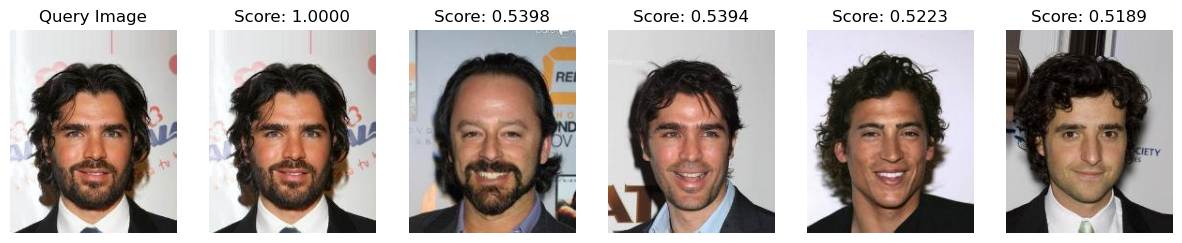

In [32]:
similarities = cosine_similarity(query_embedding_np, CelebA_gt_CelebA_original_val_embedding_vectors)

top_k = 5
sorted_indices = np.argsort(similarities[0])[::-1]

top_k_indices = sorted_indices[:top_k]
top_k_paths = [Path("./dinov2/data/datasets/CelebA/CelebA_original/val") / CelebA_gt_CelebA_original_val_embedding_names[idx] for idx in top_k_indices]
top_k_scores = [similarities[0][idx] for idx in top_k_indices]

query_image_path = Path(f"./dinov2/data/datasets/CelebA/CelebA_original/val/{query_image_name}")
query_image = Image.open(query_image_path).convert("RGB")

print("Top-5 Retrieval Results:")
for i, (path, score) in enumerate(zip(top_k_paths, top_k_scores), start=1):
    print(f"{i}. {path.name} (Score: {score:.4f})")

visualize_top_k_results(query_image, top_k_paths, top_k_scores)

### "Unadapted/Pixel" with Unanonymized Query Image

Top-5 Retrieval Results:
1. 166221.jpg (Score: 0.4669)
2. 166917.jpg (Score: 0.4368)
3. 162771.jpg (Score: 0.4218)
4. 177592.jpg (Score: 0.4084)
5. 173475.jpg (Score: 0.3917)


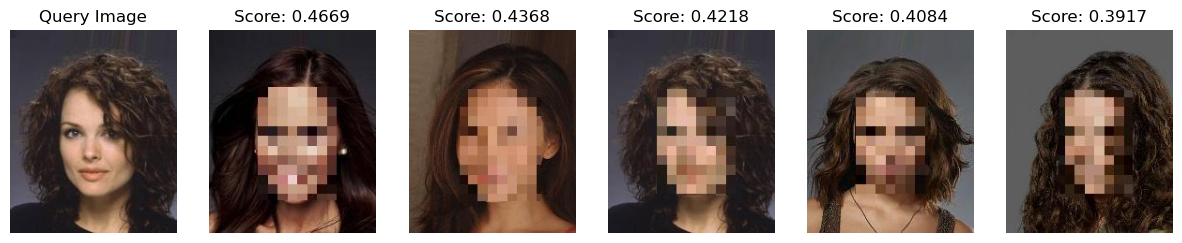

In [25]:
similarities = cosine_similarity(query_embedding_np, CelebA_gt_CelebA_pixelated_val_embedding_vectors)

top_k = 5
sorted_indices = np.argsort(similarities[0])[::-1]

top_k_indices = sorted_indices[:top_k]
top_k_paths = [Path("./dinov2/data/datasets/CelebA/CelebA_pixelated/val") / CelebA_gt_CelebA_pixelated_val_embedding_names[idx] for idx in top_k_indices]
top_k_scores = [similarities[0][idx] for idx in top_k_indices]

query_image_path = Path(f"./dinov2/data/datasets/CelebA/CelebA_original/val/{query_image_name}")
query_image = Image.open(query_image_path).convert("RGB")

print("Top-5 Retrieval Results:")
for i, (path, score) in enumerate(zip(top_k_paths, top_k_scores), start=1):
    print(f"{i}. {path.name} (Score: {score:.4f})")

visualize_top_k_results(query_image, top_k_paths, top_k_scores)

### "Unadapted/Pixel" with Anonymized Query Image

In [33]:
if query_image_name not in CelebA_gt_CelebA_pixelated_val_embedding_names:
    raise ValueError(f"Query image '{query_image_name}' not found in embeddings file.")
query_embedding_np = np.array([CelebA_gt_CelebA_pixelated_val_embedding_vectors[CelebA_gt_CelebA_pixelated_val_embedding_names.index(query_image_name)]])

Top-5 Retrieval Results:
1. 162772.jpg (Score: 1.0000)
2. 165517.jpg (Score: 0.6051)
3. 162969.jpg (Score: 0.6027)
4. 166230.jpg (Score: 0.5987)
5. 174012.jpg (Score: 0.5898)


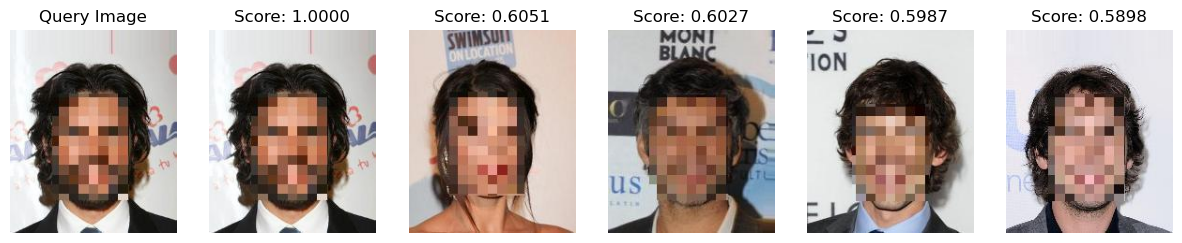

In [34]:
similarities = cosine_similarity(query_embedding_np, CelebA_gt_CelebA_pixelated_val_embedding_vectors)

top_k = 5
sorted_indices = np.argsort(similarities[0])[::-1]

top_k_indices = sorted_indices[:top_k]
top_k_paths = [Path("./dinov2/data/datasets/CelebA/CelebA_pixelated/val") / CelebA_gt_CelebA_pixelated_val_embedding_names[idx] for idx in top_k_indices]
top_k_scores = [similarities[0][idx] for idx in top_k_indices]

query_image_path = Path(f"./dinov2/data/datasets/CelebA/CelebA_pixelated/val/{query_image_name}")
query_image = Image.open(query_image_path).convert("RGB")

print("Top-5 Retrieval Results:")
for i, (path, score) in enumerate(zip(top_k_paths, top_k_scores), start=1):
    print(f"{i}. {path.name} (Score: {score:.4f})")

visualize_top_k_results(query_image, top_k_paths, top_k_scores)

### Create Ground Truth Retrieval Files

#### CelebA

In [7]:
embedding_names, embedding_vectors = load_embeddings(embeddings_file)

In [8]:
ground_truth_retrievals = {}

for idx, query_image_name in enumerate(tqdm(embedding_names, desc="Processing images")):
    query_embedding = embedding_vectors[idx].reshape(1, -1) # (n_features,) -> (1, n_features)
    similarities = cosine_similarity(query_embedding, embedding_vectors)[0]

    sorted_indices = np.argsort(similarities)[::-1]
    retrieval_results = [
        {embedding_names[i]: float(similarities[i])} for i in sorted_indices # e.g., [{"162772.jpg": 1.0000}, {"179593.jpg": 0.5398}, {"174813.jpg": 0.5394}, ...]
    ]

    ground_truth_retrievals[query_image_name] = retrieval_results # e.g., {"162772.jpg": [{"162772.jpg": 1.0000}, {"179593.jpg": 0.5398}, {"174813.jpg": 0.5394}, ...]}

Processing images: 100%|██████████| 19792/19792 [42:52<00:00,  7.69it/s]  


Ground-Truth Retrievals saved to ./retrieval_ground_truths/CelebA_retrieval_ground_truths.json.


In [10]:
pickle_file = "./retrieval_ground_truths/CelebA_retrieval_ground_truths.pkl"

with open(pickle_file, "wb") as f:
    pickle.dump(ground_truth_retrievals, f)

print(f"Ground-Truth Retrievals saved to {pickle_file}.")

Ground-Truth Retrievals saved to ./retrieval_ground_truths/CelebA_retrieval_ground_truths.pkl.


In [3]:
pickle_file = "./retrieval_ground_truths/CelebA_retrieval_ground_truths.pkl"

with open(pickle_file, "rb") as f:
    ground_truth_retrievals = pickle.load(f)

In [18]:
query_image_name = "162779.jpg"

if query_image_name in ground_truth_retrievals:
    retrieval_results = ground_truth_retrievals[query_image_name]
    print(f"Retrieval results for {query_image_name}:")
    for result in retrieval_results[:5]:
        print(result)
else:
    print(f"No retrieval results found for {query_image_name}.")

Retrieval results for 162779.jpg:
{'162779.jpg': 0.9999999999999999}
{'164677.jpg': 0.5927522547458496}
{'165630.jpg': 0.5383260807071485}
{'171549.jpg': 0.5376002517886762}
{'172525.jpg': 0.5368408649312185}


## Test MAP Calculation

In [4]:
gt_retrievals = ground_truth_retrievals

In [5]:
from mean_average_precision import PrecisionCalculator, AveragePrecisionCalculator

In [6]:
percent = 5 # the first 5 percent of the gt retrievals shall be defined as "relevant"
query_embeddings_name = "CelebA_gt_CelebAPixelatedVal_emb.json"
database_embeddings_name = "CelebA_gt_CelebAPixelatedVal_emb.json"

In [7]:
query_embeddings_file = f"./embeddings/{query_embeddings_name}"
database_embeddings_file = f"./embeddings/{database_embeddings_name}"

In [8]:
query_embedding_names, query_embedding_vectors = load_embeddings(query_embeddings_file)
database_embedding_names, database_embedding_vectors = load_embeddings(database_embeddings_file)

In [13]:
ap_calculator = AveragePrecisionCalculator(PrecisionCalculator())
all_aps = []
all_hits = {}

In [14]:
for query_idx, query_embedding_name in tqdm(enumerate(query_embedding_names[:2]), total=2, desc="Calculating MAP"):
    if query_embedding_name not in gt_retrievals:
        raise ValueError(f"Query {query_embedding_name} not found in ground truth retrievals.")

    ground_truth = gt_retrievals[query_embedding_name]
    relevant_count = int(len(ground_truth) * percent / 100)
    relevant_documents = [list(d.keys())[0] for d in ground_truth[:relevant_count]]
    
    query_embedding_vector = query_embedding_vectors[query_idx].reshape(1, -1)
    similarities = cosine_similarity(query_embedding_vector, database_embedding_vectors).flatten()

    sorted_indices = np.argsort(-similarities)
    retrieved_documents = [database_embedding_names[idx] for idx in sorted_indices]
    ap = ap_calculator.calculate_average_precision(relevant_documents, retrieved_documents)
    hits = ap_calculator.get_hits()
    
    all_aps.append(ap)
    all_hits[query_embedding_name] = hits

map_score = np.mean(all_aps)


Calculating MAP: 100%|██████████| 2/2 [00:07<00:00,  3.55s/it]


{'162771.jpg': [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  39,
  40,
  41,
  42,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  60,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  97,
  98,
  99,
  100,
  103,
  104,
  105,
  106,
  108,
  110,
  111,
  112,
  113,
  114,
  115,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  148,
  149,
  150,
  151,
  152,
  153,
  155,
  156,
  157,
  159,
  160,
  161,
  163,
  164,
  165,
  166,
  167,
  168,
  169,
  170,
  171,
  1

In [17]:
map_output_file = f"./retrieval_evaluations/map_{int(percent)}%_{query_embeddings_name}->{database_embeddings_name}.txt"
hits_output_file = f"./retrieval_evaluations/hits_{int(percent)}%_{query_embeddings_name}->{database_embeddings_name}.json"

In [ ]:
with open(hits_output_file, "w") as f:
    json.dump(all_hits, f)